Purpose of this notebook: 
* reads and summarizes the outputs from projections and smoothing
* creates LaTeX table for the paper 
* creates fig. 6 


In [56]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [212]:
%autoreload 2
%matplotlib inline 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams['figure.figsize'] = (10, 8)
import pprint

In [58]:
from __future__ import (print_function, division)
import pandas as pd
import h5py
import sys
from astropy.stats import biweight_location
import scipy

homebrew modules

In [59]:
sys.path.append("../")
import extract_catalog as ec
import get_DM_centroids as getDM
# import seaborn as sns
import compute_distance as compDist
import plot_cred_int as plotCI
import get_KDE
import compute_clst_prop as compClst

In [60]:
data_path = "../../data/test_results/"

# read in files 

In [61]:
total_clstNo = 43
date_stamp = '06_17_16'

DM_fhats = \
    h5py.File(data_path +
              "DM_fhat_clst{0}_{1}.h5".format(
            total_clstNo, date_stamp), 'r')
star_fhats = \
    h5py.File(data_path +
              "stars_fhat_clst{0}_{1}.h5".format(
            total_clstNo, date_stamp), 'r')

In [62]:
main_FOF_h5 = h5py.File(
        "../../data/" +
        "Illustris-1_fof_subhalo_myCompleteHaloCatalog_00135" +
        ".hdf5", "r")

In [63]:
rich_clst = sorted([int(no) for no in star_fhats.keys()])

In [64]:
mass_keys = [ 
    u'Group_M_Crit200',
    u'Group_M_Crit500',
    u'GroupMass'
]

In [65]:
# do cbind of 3 dfs 
masses_df = pd.concat([pd.DataFrame(
            main_FOF_h5['Group'][key][rich_clst],
            columns=[key], index=rich_clst) for key in mass_keys],
            axis=1)                        

In [66]:
%time clst_dfs = map(lambda x: ec.extract_clst(main_FOF_h5, x), rich_clst)

clstNo_mapping = {clstNo: i for i, clstNo in enumerate(rich_clst)}

CPU times: user 719 ms, sys: 20.4 s, total: 21.2 s
Wall time: 21.1 s


# projection dependent part

In [ ]:
uber_df = pd.read_hdf("../../data/uber_df_{}.h5".format(date_stamp), "df")
dom_peak_gpby = uber_df.groupby(['peak_id', 'bin_width'])
dom_peak_df_25 = dom_peak_gpby.get_group((0, 25.0))
dom_peak_df_25['clstNo'] = dom_peak_df_25.index

# projection independent part 

In [68]:
# fraction of subfind halo mass / amount of substructures 
relaxedness0= np.array(
    [compClst.compute_relaxedness0(
     clst_dfs[clstNo_mapping[clstNo]], main_FOF_h5, clstNo) 
     for clstNo in rich_clst])

# eccentricity / asymmetry
relaxedness1= np.array(
    [compClst.compute_relaxedness1(
     clst_dfs[clstNo_mapping[clstNo]], main_FOF_h5, clstNo) 
     for clstNo in rich_clst])

clst_prop_df = compDist.construct_uber_result_df(
    star_fhats, DM_fhats, main_FOF_h5
)
clst_prop_df.index = masses_df.index
mega_clst_prop_df = pd.concat([clst_prop_df, masses_df], axis=1)

mega_clst_prop_df['relaxedness0'] = relaxedness0
mega_clst_prop_df['relaxedness1'] = relaxedness1

del mega_clst_prop_df['M200C']

# compute correlations between offsets and other properties

In [72]:
def str_formatter(var):
    return '{0:.2f}'.format(var)

gather a bunch of properties for computing the correlation 

* median(total peak density)
* median(KDE)
* max(total_peak_dens)
* max(KDE)
* richness 
* group_M_Crit200
* group_M_Crit500
* groupMass
* relaxedness0
* relaxedness1 

In [77]:
scipy.stats.pearsonr(,)

(0.3788051464979465, 0.0)

very high correlation between different relaxedness measurements 

In [78]:
scipy.stats.pearsonr(relaxedness0, relaxedness1)

(0.81622389436144904, 2.5530624557341724e-11)

# plot the projection uncertainty by cluster

In [177]:
dom_peak_clst_gpby = dom_peak_df_25.groupby('clstNo')
rich_clst_nos = np.unique(dom_peak_df_25.index)
clst_dom_KDE_stat = [dom_peak_clst_gpby.get_group(clstNo)['Delta_y_KDE']
                     for clstNo in clstNo_mapping]
clst_total_peak_dens_stat = [
    dom_peak_clst_gpby.get_group(clstNo)['total_peaks_dens']
    for clstNo in rich_clst_nos]

# compute correlation between peak measurements

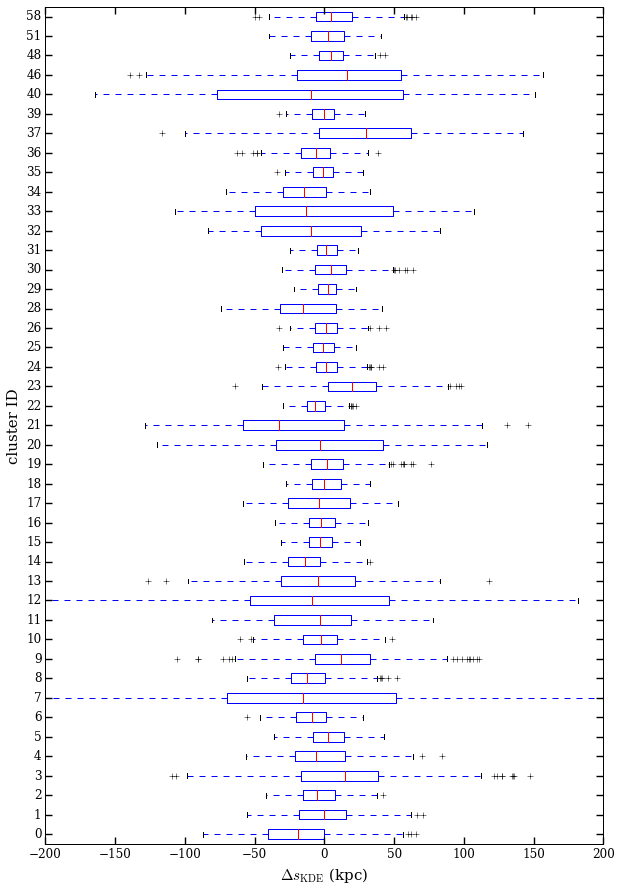

In [149]:
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(111)
KDE_proj_uncertainty_dict  = plt.boxplot(clst_dom_KDE_stat, vert=0)

labels = [item.get_text() for item in ax.get_yticklabels()]
for i, clstNo in enumerate(sorted(rich_clst)):
    labels[i] = '{0}'.format(clstNo)

ax.set_yticklabels(labels)
ax.set_xlim(-200, 200)
ax.set_ylabel('cluster ID')
ax.set_xlabel(r'$ \Delta s_{\rm KDE}$ (kpc)')
plt.savefig('../../paper/figures/finalized/projected_KDE_offset_distribution.pdf',
            bbox_inches='tight')

# summarize the projection statistics for each cluster and put them in the dataframe with individual cluster properties

In [187]:
proj_KDE_stat = pd.DataFrame({
        rich_clst_nos[i]: clst_dom_KDE_stat[i].describe() 
        for i in range(len(rich_clst_nos))})
mega_clst_prop_df['Delta_y_KDE_max'] = proj_KDE_stat.transpose()['max']
mega_clst_prop_df['median_tot_peak_dens'] = \
    [np.median(peak_stat) for peak_stat in 
     clst_total_peak_dens_stat]

# compute the correlation between different cluster properties

In [226]:
clst_props = list(mega_clst_prop_df.columns)
clst_props.remove('clstNo')

In [224]:
import itertools

In [227]:
comb = itertools.combinations(clst_props, 2)

In [229]:
correlation_dict = {pair: scipy.stats.pearsonr(mega_clst_prop_df[pair[0]], 
                                         mega_clst_prop_df[pair[1]])
                    for pair in itertools.combinations(clst_props, 2)}

the first entry is correlation, the second is the p-value that the correlation arises by chance

In [230]:
pprint.pprint(correlation_dict)

{('Delta_y_KDE_max', 'median_tot_peak_dens'): (0.76705795538081156,
                                               1.9883061893306371e-09),
 (u'GroupMass', 'Delta_y_KDE_max'): (0.13906937249147525, 0.37378841916021255),
 (u'GroupMass', 'median_tot_peak_dens'): (0.28029997537498896,
                                          0.068671219254671484),
 (u'GroupMass', 'relaxedness0'): (-0.037633843125862064, 0.81064464594051366),
 (u'GroupMass', 'relaxedness1'): (0.036462262759905488, 0.81643657791910795),
 (u'Group_M_Crit200', 'Delta_y_KDE_max'): (-0.13739113695701075,
                                           0.37963838244671988),
 (u'Group_M_Crit200', u'GroupMass'): (0.92993892792417232,
                                      2.0360906408366376e-19),
 (u'Group_M_Crit200', u'Group_M_Crit500'): (0.96521905348905224,
                                            1.659433213841298e-25),
 (u'Group_M_Crit200', 'median_tot_peak_dens'): (0.0077292943696930265,
                                       

# plot the `total_peak_dens` per cluster per projection

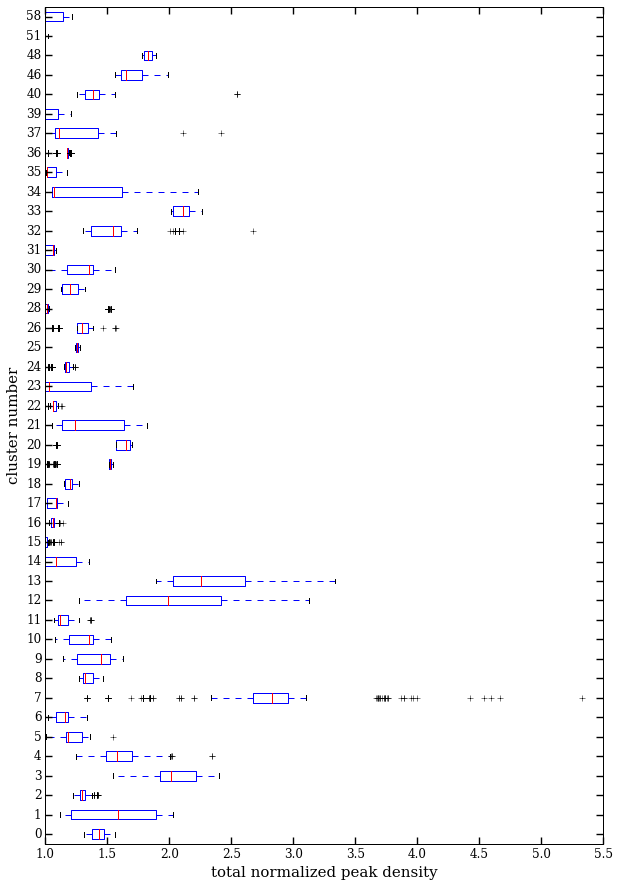

In [49]:
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(111)
_ = plt.boxplot(clst_total_peak_dens_stat, vert=0)

labels = [item.get_text() for item in ax.get_yticklabels()]
for i in range(len(labels)):
    labels[i] = rich_clst_nos[i]

ax.set_yticklabels(labels)

ax.set_ylabel('cluster number')
ax.set_xlabel('total normalized peak density')